In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

In [5]:
with open('numpy arrays/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)
    print('X loaded')
with open('numpy arrays/y.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)
    print('y loaded')

X loaded
y loaded


In [6]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

In [7]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


In [8]:
new_X = tf.image.resize(
    X, [100,100], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
new_X.shape
X = np.array(new_X)

In [9]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam 

In [10]:
# Using early stopping and reduce lr on plateau to control the performance
cb_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0) 
cb_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')

cbs = [cb_1,cb_2]

In [11]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 42, stratify=y) 

In [12]:
model = Sequential()
# tf.keras.applications.InceptionResNetV2(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000,
#     classifier_activation='softmax', **kwargs
# )
conv_base = tf.keras.applications.Xception(input_shape=(100,100,3), include_top=False, pooling='max',weights='imagenet')
# conv_base.trainable = False
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax')) 

train_layers = [layer for layer in conv_base.layers[::-1][:5]]

for layer in conv_base.layers:
  if layer in train_layers:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

83689472/83683744 [==============================] - 1s 0us/step


In [13]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 25,084,461
Trainable params: 25,021,741
Non-trainable params: 62,720
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=8, callbacks=cbs,verbose=1) 

Epoch 1/8
305/413 [=====================>........] - ETA: 2:28 - loss: 580.1348 - accuracy: 0.6732

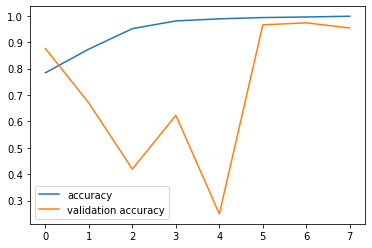

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()
plt.show()

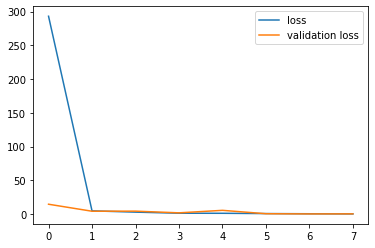

In [16]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

In [17]:
predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[889   1   0  12   2]
 [  2 813  56   0   4]
 [  0  21 854   0   0]
 [ 14   0   0 860   1]
 [  1  52   3  34 785]]


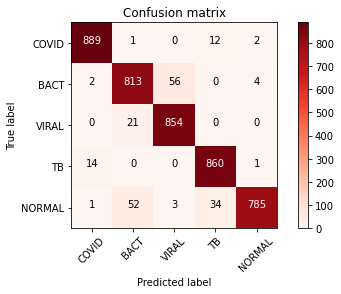

In [20]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])

In [21]:
print(classification_report(y_test, predictions));

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       904
           1       0.92      0.93      0.92       875
           2       0.94      0.98      0.96       875
           3       0.95      0.98      0.97       875
           4       0.99      0.90      0.94       875

    accuracy                           0.95      4404
   macro avg       0.95      0.95      0.95      4404
weighted avg       0.95      0.95      0.95      4404



In [19]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes
                          ,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()